In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']; print(X.shape, y.shape)

(70000, 784) (70000,)


In [3]:
import matplotlib.pyplot as plt

some_digit =X[0].reshape(28,28)
plt.imshow(some_digit, cmap='binary')
plt.axis('off')
plt.show()

y[0]

<Figure size 640x480 with 1 Axes>

'5'

In [4]:
import numpy as np
y = y.astype(np.uint8)
y[0]

5

In [73]:
def plt_images(instances, images_per_row, **options):
    size=28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    row_images=[]
    n_rows = (len(instances)-1)//images_per_row + 1
    n_empty = n_rows*images_per_row - len(instances)
    images.append(np.zeros((size,size*n_empty)))
    for row in range(n_rows):
        r_images=images[row*images_per_row : (row+1)*images_per_row]
        row_images.append(np.concatenate(r_images,axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

10


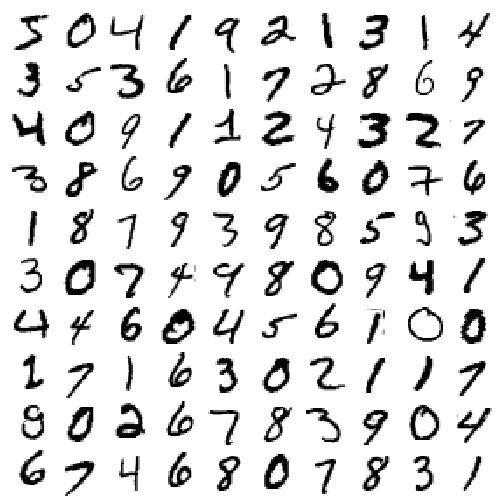

In [6]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plt_images(example_images, images_per_row=10)
plt.show()

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)
y_train[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict(some_digit.reshape(1,784))

array([ True])

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import clone

split=StratifiedShuffleSplit(n_splits=3, random_state=42)

for train_index, test_index in split.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    
    train_set = X_train[train_index]
    train_y = y_train_5[train_index]
    test_set = X_train[test_index]
    test_y = y_train_5[test_index]
    
    clone_clf.fit(train_set, train_y)
    predicted_y= clone_clf.predict(test_set)
    accuracy=sum(predicted_y==test_y)/len(test_y)
    print('Accuracy:', round(accuracy,3))

Accuracy: 0.922
Accuracy: 0.966
Accuracy: 0.971


In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.base import BaseEstimator

class NullClf(BaseEstimator):
    def fit(self, X, y):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype='bool')

In [14]:
never_5_clf = NullClf()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [15]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_pred[0:5]

array([ True, False, False, False, False])

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred, y_train_5)

array([[53892,  1891],
       [  687,  3530]], dtype=int64)

In [17]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_pred)

0.8370879772350012

In [18]:
recall_score(y_train_5, y_pred)

0.6511713705958311

In [19]:
y_score = sgd_clf.decision_function(some_digit.reshape(1,784))
y_score

array([2164.22030239])

In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [21]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

0.4799852425751706
3370.0194991439557


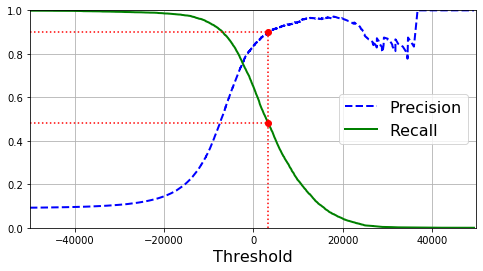

In [22]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)       
    plt.grid(True)                            
    plt.axis([-50000, 50000, 0, 1])             

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(recall_90_precision)
print(threshold_90_precision)

plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")              
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                            
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                                     
plt.show()

In [23]:
(y_pred == (y_scores > 0)).all()

True

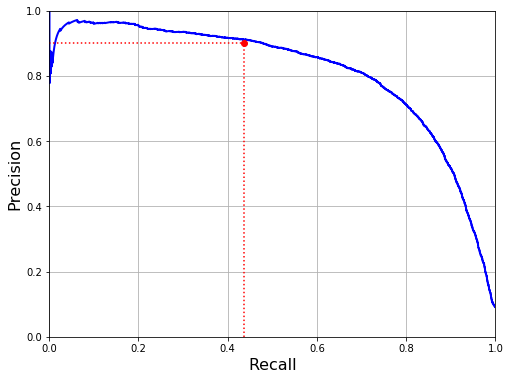

In [24]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

In [25]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [26]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [27]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

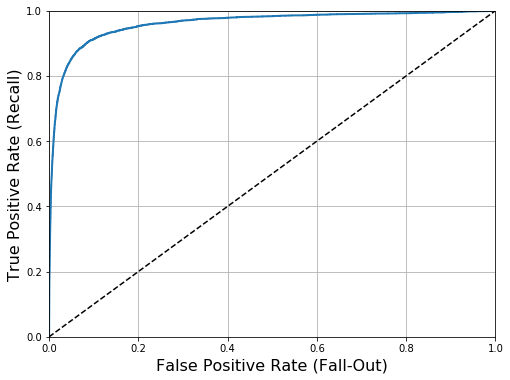

In [29]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                       
plot_roc_curve(fpr, tpr)                                    
plt.show()

In [30]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [31]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_proba = cross_val_predict(forest_clf, X_train, y_train_5,
                           cv=3, method='predict_proba')
print(y_proba.shape)
print('\n',y_proba[:5])

(60000, 2)

 [[0.11 0.89]
 [0.99 0.01]
 [0.96 0.04]
 [1.   0.  ]
 [0.99 0.01]]


In [32]:
y_scores_forest = y_proba[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

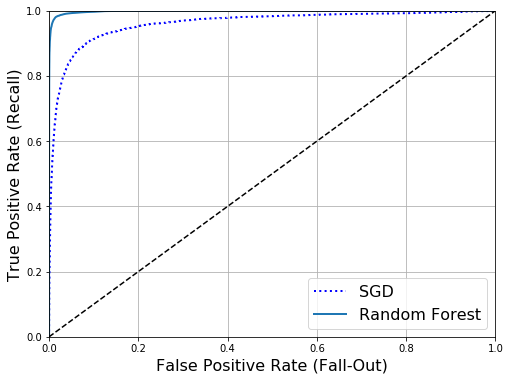

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [35]:
y_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_pred_forest)

0.9905083315756169

In [36]:
recall_score(y_train_5, y_pred_forest)

0.8662608374838591

# Multiclass-Classification

In [37]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [38]:
some_digit=some_digit.reshape(1,784)
svm_clf.predict(some_digit)

array([5], dtype=uint8)

In [39]:
some_digit_scores = svm_clf.decision_function(some_digit)
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [40]:
np.argmax(some_digit_scores)

5

In [41]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [42]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma='auto', random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict(some_digit)

array([5], dtype=uint8)

In [43]:
len(ovr_clf.estimators_)

10

In [44]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict(some_digit)

array([3], dtype=uint8)

In [45]:
sgd_clf.decision_function(some_digit)

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [46]:
cross_val_score(sgd_clf, X_train, y_train, cv=3)

array([0.87082583, 0.87089354, 0.88628294])

In [47]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

C:\Users\user\Anaconda3\Lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

In [62]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\Users\user\Anaconda3\Lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]],
      dtype=int64)

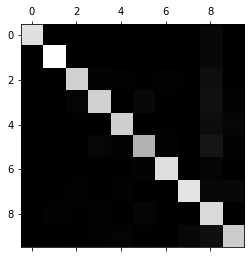

In [63]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [64]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
row_sums.shape

(10, 1)

In [65]:
norm_conf_mx = conf_mx / row_sums
norm_conf_mx

array([[9.41414824e-01, 0.00000000e+00, 3.54550059e-03, 1.01300017e-03,
        1.51950025e-03, 7.25983454e-03, 6.24683437e-03, 1.01300017e-03,
        3.78186730e-02, 1.68833361e-04],
       [0.00000000e+00, 9.48976565e-01, 5.63630970e-03, 3.41145061e-03,
        5.93295758e-04, 6.52625334e-03, 5.93295758e-04, 1.18659152e-03,
        3.15929991e-02, 1.48323939e-03],
       [4.36388050e-03, 4.53172205e-03, 8.79825445e-01, 1.51057402e-02,
        1.19167506e-02, 4.36388050e-03, 1.04061766e-02, 6.04229607e-03,
        6.22692179e-02, 1.17489090e-03],
       [3.91453270e-03, 2.77279400e-03, 1.90833469e-02, 8.51410863e-01,
        3.26211059e-04, 3.39259501e-02, 4.56695482e-03, 6.52422117e-03,
        6.60577394e-02, 1.14173870e-02],
       [2.05409106e-03, 2.39643958e-03, 8.21636426e-03, 1.71174255e-03,
        8.88736734e-01, 1.71174255e-03, 6.16227319e-03, 4.45053064e-03,
        5.64875043e-02, 2.80725779e-02],
       [5.16509869e-03, 2.76701716e-03, 6.08743774e-03, 3.06216565e-02,
   

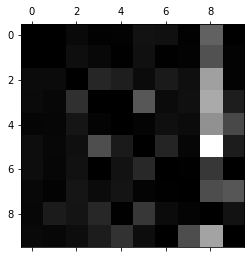

In [68]:
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [69]:
cl_a, cl_b = 3, 5

X_aa = X_train[(y_train==cl_a) & (y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a) & (y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b) & (y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b) & (y_train_pred==cl_b)]

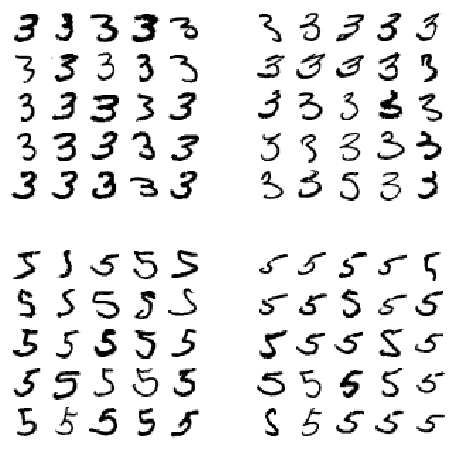

In [74]:
plt.figure(figsize=(8,8))
plt.subplot(221); plt_images(X_aa[:25], images_per_row=5)
plt.subplot(222); plt_images(X_ab[:25], images_per_row=5)
plt.subplot(223); plt_images(X_ba[:25], images_per_row=5)
plt.subplot(224); plt_images(X_bb[:25], images_per_row=5)
plt.show()

# Multi-Label Classification

In [77]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = y_train>=7
y_train_odd = y_train % 2 ==1
y_multilabel = np.c_[y_train_large, y_train_odd]
print(y_multilabel.shape)
print(y_multilabel[:5])

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

(60000, 2)
[[False  True]
 [False False]
 [False False]
 [False  True]
 [ True  True]]


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [78]:
knn_clf.predict(some_digit)

array([[False,  True]])

In [ ]:
y_train_knn_pred = knn_clf.predict(X_train)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

# Multi-Output Classification 

In [ ]:
noise = np.random.randint(0, 100, size=(len(X_train),784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
plt.show()